In [1]:
# Cell 1: Imports and Dataset Loading (with trash class removal)
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

image_size = 96
X = []
y = []

# ✅ Use relative path assuming "dataset-resized" is in the current working directory
data_dir = "dataset-resized"

for label in os.listdir(data_dir):
    if label.lower() == 'trash':
        continue
    class_path = os.path.join(data_dir, label)
    if not os.path.isdir(class_path):
        continue
    for file in os.listdir(class_path):
        img_path = os.path.join(class_path, file)
        img = cv2.imread(img_path)
        if img is not None:
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img = cv2.resize(img, (image_size, image_size))
            X.append(img)
            y.append(label)

X = np.array(X).astype('float32') / 255.0
y = np.array(y)

print(f"Loaded {len(X)} images")
print("Classes found (without trash):", np.unique(y))

# Label Encoding and Train-Test Split
le = LabelEncoder()
y_encoded = le.fit_transform(y)
y_cat = to_categorical(y_encoded)

X_train, X_test, y_train, y_test = train_test_split(
    X, y_cat, test_size=0.2, stratify=y_encoded, random_state=42
)

print(f"Train: {X_train.shape}, Test: {X_test.shape}")
print("Encoded classes:", le.classes_)


Loaded 2189 images
Classes found (without trash): ['cardboard' 'glass' 'metal' 'paper' 'plastic']
Train: (1751, 96, 96, 3), Test: (438, 96, 96, 3)
Encoded classes: ['cardboard' 'glass' 'metal' 'paper' 'plastic']


In [2]:
# Cell 2: Data Augmentation
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
    rotation_range=15,
    zoom_range=0.1,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True
)
datagen.fit(X_train)


In [3]:
import tensorflow as tf
import tensorflow.keras.backend as K
from tensorflow.keras.losses import Loss

class FocalLoss(Loss):
    def __init__(self, gamma=2.0, alpha=0.25, **kwargs):
        super(FocalLoss, self).__init__(**kwargs)
        self.gamma = gamma
        self.alpha = alpha

    def call(self, y_true, y_pred):
        epsilon = K.epsilon()
        y_pred = K.clip(y_pred, epsilon, 1. - epsilon)
        cross_entropy = -y_true * K.log(y_pred)
        weight = self.alpha * K.pow(1 - y_pred, self.gamma)
        return K.mean(weight * cross_entropy, axis=-1)


In [4]:
# Cell 3: MobileNetV2-based Transfer Learning Model
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Input
from tensorflow.keras.optimizers import Adam

# Load MobileNetV2 without top classifier
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(96, 96, 3))

# Freeze base model initially
base_model.trainable = False

# Add custom head
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
output = Dense(5, activation='softmax')(x)

# Final model
model = Model(inputs=base_model.input, outputs=output)

# Compile with Focal Loss
model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss=FocalLoss(gamma=2.0, alpha=0.25),
    metrics=['accuracy']
)

model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)      │ (None, 96, 96, 3)         │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ Conv1 (Conv2D)                │ (None, 48, 48, 32)        │             864 │ input_layer[0][0]          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ bn_Conv1 (BatchNormalization) │ (None, 48, 48, 32)        │             128 │ Conv1[0][0]                │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ Conv1_relu (ReLU)             │ (None, 48, 48, 32)        │               0 │ bn_Conv1[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ expanded_conv_depthwise       │ (None, 48, 48, 32)        │             288 │ Conv1_relu[0][0]           │
│ (DepthwiseConv2D)             │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ expanded_conv_depthwise_BN    │ (None, 48, 48, 32)        │             128 │ expanded_conv_depthwise[0… │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ expanded_conv_depthwise_relu  │ (None, 48, 48, 32)        │               0 │ expanded_conv_depthwise_B… │
│ (ReLU)                        │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ expanded_conv_project         │ (None, 48, 48, 16)        │             512 │ expanded_conv_depthwise_r… │
│ (Conv2D)                      │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ expanded_conv_project_BN      │ (None, 48, 48, 16)        │              64 │ expanded_conv_project[0][… │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block_1_expand (Conv2D)       │ (None, 48, 48, 96)        │           1,536 │ expanded_conv_project_BN[… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block_1_expand_BN             │ (None, 48, 48, 96)        │             384 │ block_1_expand[0][0]       │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block_1_expand_relu (ReLU)    │ (None, 48, 48, 96)        │               0 │ block_1_expand_BN[0][0]    │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block_1_pad (ZeroPadding2D)   │ (None, 49, 49, 96)        │               0 │ block_1_expand_relu[0][0]  │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block_1_depthwise             │ (None, 24, 24, 96)        │             864 │ block_1_pad[0][0]          │
│ (DepthwiseConv2D)             │                           │               

 Total params: 2,422,597 (9.24 MB)

 Trainable params: 164,613 (643.02 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [5]:
# Cell 4: Class Weights & Early Stopping
from sklearn.utils import class_weight
from tensorflow.keras.callbacks import EarlyStopping

# Convert back to original labels for class weight computation
y_train_labels = np.argmax(y_train, axis=1)
weights = class_weight.compute_class_weight(class_weight='balanced',
                                             classes=np.unique(y_train_labels),
                                             y=y_train_labels)
class_weights = {i: w for i, w in enumerate(weights)}
print("Class weights:", class_weights)

early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)


Class weights: {0: 1.2034364261168384, 1: 0.8733167082294264, 2: 1.2075862068965517, 3: 0.9119791666666667, 4: 0.9096103896103896}


In [6]:
# Cell 5: Model Training
history = model.fit(
    datagen.flow(X_train, y_train, batch_size=32),
    validation_data=(X_test, y_test),
    epochs=30,
    callbacks=[early_stop],
    class_weight=class_weights,
    verbose=1
)


C:\Python312\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
55/55 ━━━━━━━━━━━━━━━━━━━━ 14s 168ms/step - accuracy: 0.2512 - loss: 0.0870 - val_accuracy: 0.4406 - val_loss: 0.0389
Epoch 2/30
55/55 ━━━━━━━━━━━━━━━━━━━━ 9s 161ms/step - accuracy: 0.4312 - loss: 0.0485 - val_accuracy: 0.5525 - val_loss: 0.0295
Epoch 3/30
55/55 ━━━━━━━━━━━━━━━━━━━━ 9s 158ms/step - accuracy: 0.4877 - loss: 0.0386 - val_accuracy: 0.6073 - val_loss: 0.0253
Epoch 4/30
55/55 ━━━━━━━━━━━━━━━━━━━━ 8s 144ms/step - accuracy: 0.5402 - loss: 0.0312 - val_accuracy: 0.6553 - val_loss: 0.0226
Epoch 5/30
55/55 ━━━━━━━━━━━━━━━━━━━━ 8s 138ms/step - accuracy: 0.5833 - loss: 0.0274 - val_accuracy: 0.6849 - val_loss: 0.0211
Epoch 6/30
55/55 ━━━━━━━━━━━━━━━━━━━━ 7s 134ms/step - accuracy: 0.5959 - loss: 0.0272 - val_accuracy: 0.7009 - val_loss: 0.0197
Epoch 7/30
55/55 ━━━━━━━━━━━━━━━━━━━━ 8s 141ms/step - accuracy: 0.6311 - loss: 0.0234 - val_accuracy: 0.7215 - val_loss: 0.0189
Epoch 8/30
55/55 ━━━━━━━━━━━━━━━━━━━━ 8s 145ms/step - accuracy: 0.6653 - loss: 0.0221 - val_accuracy: 0

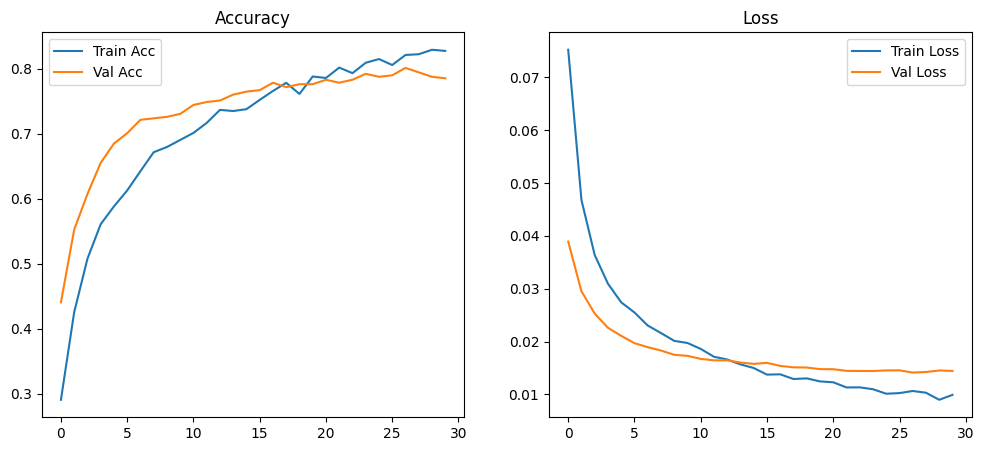

In [7]:
# Cell 6: Plot Accuracy & Loss
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.legend()
plt.title('Accuracy')

plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.legend()
plt.title('Loss')
plt.show()


Test Accuracy: 80.14%
14/14 ━━━━━━━━━━━━━━━━━━━━ 3s 147ms/step
              precision    recall  f1-score   support

   cardboard       0.84      0.96      0.90        73
       glass       0.83      0.72      0.77       100
       metal       0.68      0.90      0.77        72
       paper       0.88      0.75      0.81        96
     plastic       0.80      0.74      0.77        97

    accuracy                           0.80       438
   macro avg       0.81      0.81      0.80       438
weighted avg       0.81      0.80      0.80       438



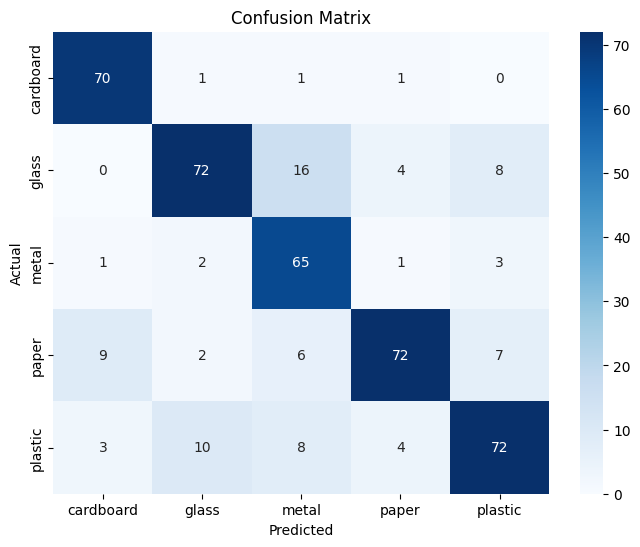

In [8]:
# Cell 7: Evaluation & Classification Report
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

test_loss, test_acc = model.evaluate(X_test, y_test, verbose=0)
print(f"Test Accuracy: {test_acc*100:.2f}%")

y_pred = model.predict(X_test)
y_pred_labels = np.argmax(y_pred, axis=1)
y_true_labels = np.argmax(y_test, axis=1)

print(classification_report(y_true_labels, y_pred_labels, target_names=le.classes_))

cm = confusion_matrix(y_true_labels, y_pred_labels)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=le.classes_, yticklabels=le.classes_)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


In [9]:
import os

dataset_path = "dataset-resized"  # make sure this path is correct
class_counts = {}

for class_name in os.listdir(dataset_path):
    class_dir = os.path.join(dataset_path, class_name)
    if os.path.isdir(class_dir):
        image_count = len([f for f in os.listdir(class_dir) if f.lower().endswith(('.png', '.jpg', '.jpeg'))])
        class_counts[class_name] = image_count

print(class_counts)


{'cardboard': 364, 'glass': 501, 'metal': 362, 'paper': 480, 'plastic': 482, 'trash': 137}


In [10]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Enhanced augmentation to improve generalization and class balance support
datagen = ImageDataGenerator(
    rotation_range=25,
    width_shift_range=0.15,
    height_shift_range=0.15,
    shear_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

datagen.fit(X_train)


In [11]:
import tensorflow as tf
import tensorflow.keras.backend as K
from tensorflow.keras.losses import Loss

class FocalLoss(Loss):
    def __init__(self, gamma=2., alpha=0.25):
        super().__init__()
        self.gamma = gamma
        self.alpha = alpha

    def call(self, y_true, y_pred):
        epsilon = K.epsilon()
        y_pred = K.clip(y_pred, epsilon, 1. - epsilon)
        cross_entropy = -y_true * K.log(y_pred)
        weight = self.alpha * K.pow(1 - y_pred, self.gamma)
        return K.mean(weight * cross_entropy, axis=-1)

# Re-compile the model with Focal Loss
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
              loss=FocalLoss(gamma=2.0, alpha=0.25),
              metrics=['accuracy'])


In [12]:
from tensorflow.keras.callbacks import ReduceLROnPlateau

# Reduce LR when a metric has stopped improving
lr_reducer = ReduceLROnPlateau(monitor='val_loss', factor=0.5,
                               patience=3, min_lr=1e-6, verbose=1)

# Retrain
history2 = model.fit(
    datagen.flow(X_train, y_train, batch_size=32),
    validation_data=(X_test, y_test),
    epochs=30,
    callbacks=[early_stop, lr_reducer],
    class_weight=class_weights,
    verbose=1
)


Epoch 1/30


C:\Python312\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


55/55 ━━━━━━━━━━━━━━━━━━━━ 14s 173ms/step - accuracy: 0.7827 - loss: 0.0125 - val_accuracy: 0.7945 - val_loss: 0.0141 - learning_rate: 1.0000e-04
Epoch 2/30
55/55 ━━━━━━━━━━━━━━━━━━━━ 9s 160ms/step - accuracy: 0.8039 - loss: 0.0109 - val_accuracy: 0.7945 - val_loss: 0.0143 - learning_rate: 1.0000e-04
Epoch 3/30
55/55 ━━━━━━━━━━━━━━━━━━━━ 8s 149ms/step - accuracy: 0.7959 - loss: 0.0112 - val_accuracy: 0.7945 - val_loss: 0.0139 - learning_rate: 1.0000e-04
Epoch 4/30
55/55 ━━━━━━━━━━━━━━━━━━━━ 8s 153ms/step - accuracy: 0.8120 - loss: 0.0111 - val_accuracy: 0.8105 - val_loss: 0.0139 - learning_rate: 1.0000e-04
Epoch 5/30
55/55 ━━━━━━━━━━━━━━━━━━━━ 8s 152ms/step - accuracy: 0.8255 - loss: 0.0099 - val_accuracy: 0.8014 - val_loss: 0.0142 - learning_rate: 1.0000e-04
Epoch 6/30
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step - accuracy: 0.8184 - loss: 0.0100
Epoch 6: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-05.
55/55 ━━━━━━━━━━━━━━━━━━━━ 8s 153ms/step - accuracy: 0.8183 - loss: 

✅ Updated Test Accuracy: 80.37%
14/14 ━━━━━━━━━━━━━━━━━━━━ 3s 150ms/step
              precision    recall  f1-score   support

   cardboard       0.88      0.96      0.92        73
       glass       0.83      0.73      0.78       100
       metal       0.67      0.90      0.77        72
       paper       0.87      0.78      0.82        96
     plastic       0.79      0.71      0.75        97

    accuracy                           0.80       438
   macro avg       0.81      0.82      0.81       438
weighted avg       0.81      0.80      0.80       438



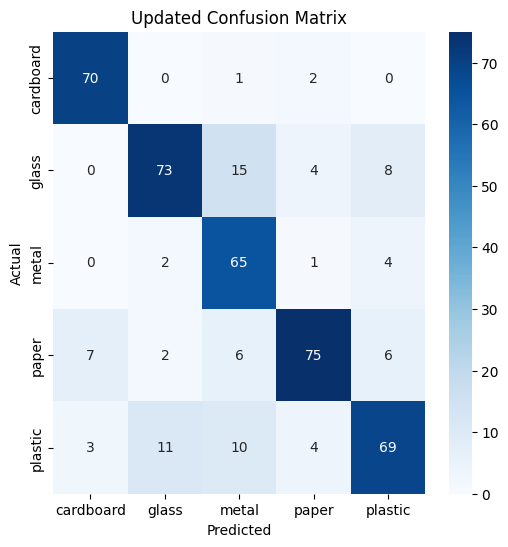

In [13]:
# Re-evaluate and plot updated metrics
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=0)
print(f"✅ Updated Test Accuracy: {test_acc * 100:.2f}%")

y_pred = model.predict(X_test)
y_pred_labels = np.argmax(y_pred, axis=1)
y_true_labels = np.argmax(y_test, axis=1)

from sklearn.metrics import classification_report, confusion_matrix
print(classification_report(y_true_labels, y_pred_labels, target_names=le.classes_))

import seaborn as sns
import matplotlib.pyplot as plt
cm = confusion_matrix(y_true_labels, y_pred_labels)
plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Updated Confusion Matrix")
plt.show()


In [14]:
# A: Oversample underrepresented classes in memory
from collections import Counter
from sklearn.utils import resample

# Decode one-hot back to class indices
y_labels = np.argmax(y_train, axis=1)
X_aug = []
y_aug = []

# Find max class count
counts = Counter(y_labels)
max_count = max(counts.values())

for cls in np.unique(y_labels):
    cls_indices = np.where(y_labels == cls)[0]
    X_cls = X_train[cls_indices]
    y_cls = y_train[cls_indices]
    
    X_upsampled, y_upsampled = resample(X_cls, y_cls,
                                        replace=True,
                                        n_samples=max_count,
                                        random_state=42)
    X_aug.append(X_upsampled)
    y_aug.append(y_upsampled)

# Concatenate all oversampled data
X_train_balanced = np.concatenate(X_aug)
y_train_balanced = np.concatenate(y_aug)

print("New training shape:", X_train_balanced.shape, y_train_balanced.shape)


New training shape: (2005, 96, 96, 3) (2005, 5)


In [15]:
from tensorflow.keras.callbacks import ReduceLROnPlateau

# Define learning rate reducer callback
lr_reduce = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=3,
    verbose=1,
    min_lr=1e-6
)


In [16]:
# B: Retrain using balanced data
history_balanced = model.fit(
    datagen.flow(X_train_balanced, y_train_balanced, batch_size=32),
    validation_data=(X_test, y_test),
    epochs=30,
    callbacks=[early_stop, lr_reduce],
    verbose=1
)


Epoch 1/30


C:\Python312\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


63/63 ━━━━━━━━━━━━━━━━━━━━ 12s 145ms/step - accuracy: 0.8320 - loss: 0.0096 - val_accuracy: 0.8014 - val_loss: 0.0136 - learning_rate: 2.5000e-05
Epoch 2/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 10s 151ms/step - accuracy: 0.8366 - loss: 0.0095 - val_accuracy: 0.8059 - val_loss: 0.0134 - learning_rate: 2.5000e-05
Epoch 3/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 9s 140ms/step - accuracy: 0.8426 - loss: 0.0095 - val_accuracy: 0.8082 - val_loss: 0.0136 - learning_rate: 2.5000e-05
Epoch 4/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 9s 139ms/step - accuracy: 0.8483 - loss: 0.0088 - val_accuracy: 0.8105 - val_loss: 0.0134 - learning_rate: 2.5000e-05
Epoch 5/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 9s 144ms/step - accuracy: 0.8232 - loss: 0.0094 - val_accuracy: 0.8128 - val_loss: 0.0133 - learning_rate: 2.5000e-05
Epoch 6/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 9s 145ms/step - accuracy: 0.8333 - loss: 0.0092 - val_accuracy: 0.8059 - val_loss: 0.0135 - learning_rate: 2.5000e-05
Epoch 7/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 10s 155ms/step - accuracy: 0.8345 -

In [17]:
# C: Evaluate again
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=0)
print(f"🎯 New Test Accuracy after oversampling: {test_acc * 100:.2f}%")


🎯 New Test Accuracy after oversampling: 81.28%


In [18]:
model.save("model/final_material_model.keras")
print("model saved")

model saved


In [19]:
from sklearn.preprocessing import LabelEncoder
import joblib
import os

# Define class names in the correct order
class_names = ['cardboard', 'glass', 'metal', 'paper', 'plastic']

# Fit the LabelEncoder
le = LabelEncoder()
le.fit(class_names)

# Ensure model directory exists
os.makedirs("model", exist_ok=True)

# Save the encoder
joblib.dump(le, "model/final_label_encoder.pkl")

# Optional: print classes to verify
print("Classes saved in label encoder:", le.classes_)


Classes saved in label encoder: ['cardboard' 'glass' 'metal' 'paper' 'plastic']


In [20]:
from sklearn.preprocessing import LabelEncoder
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

# Step 1: Define class names
class_names = ['cardboard', 'glass', 'metal', 'paper', 'plastic']

# Step 2: Fit LabelEncoder
le = LabelEncoder()
le.fit(class_names)

# Step 3: Decode y_train back to string labels
y_train_labels = le.inverse_transform(np.argmax(y_train, axis=1))

# Step 4: Compute class weights (convert classes to np.array)
class_weights = compute_class_weight(class_weight='balanced', classes=np.array(class_names), y=y_train_labels)
class_weight_dict = {i: weight for i, weight in enumerate(class_weights)}

print("Class weights:", class_weight_dict)


Class weights: {0: 1.2034364261168384, 1: 0.8733167082294264, 2: 1.2075862068965517, 3: 0.9119791666666667, 4: 0.9096103896103896}


In [21]:
for i, layer in enumerate(model.layers):
    print(i, layer.name, layer.__class__.__name__)


0 input_layer InputLayer
1 Conv1 Conv2D
2 bn_Conv1 BatchNormalization
3 Conv1_relu ReLU
4 expanded_conv_depthwise DepthwiseConv2D
5 expanded_conv_depthwise_BN BatchNormalization
6 expanded_conv_depthwise_relu ReLU
7 expanded_conv_project Conv2D
8 expanded_conv_project_BN BatchNormalization
9 block_1_expand Conv2D
10 block_1_expand_BN BatchNormalization
11 block_1_expand_relu ReLU
12 block_1_pad ZeroPadding2D
13 block_1_depthwise DepthwiseConv2D
14 block_1_depthwise_BN BatchNormalization
15 block_1_depthwise_relu ReLU
16 block_1_project Conv2D
17 block_1_project_BN BatchNormalization
18 block_2_expand Conv2D
19 block_2_expand_BN BatchNormalization
20 block_2_expand_relu ReLU
21 block_2_depthwise DepthwiseConv2D
22 block_2_depthwise_BN BatchNormalization
23 block_2_depthwise_relu ReLU
24 block_2_project Conv2D
25 block_2_project_BN BatchNormalization
26 block_2_add Add
27 block_3_expand Conv2D
28 block_3_expand_BN BatchNormalization
29 block_3_expand_relu ReLU
30 block_3_pad ZeroPadding2